In [1]:
import nibabel as nb
import os, sys
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ptitprince as pt
import seaborn as sns
from scipy import stats
import matplotlib.gridspec as gridspec

from aidhs.aidhs_cohort_hip import AidhsCohort, AidhsSubject
from aidhs.paths import BASE_PATH
import random


Setting BASE_PATH to /home/mathilde/Documents/projects/surHippo/processes/230315_preprocess_manuscript


### Load volumes

In [3]:
features_title = {
                '.hippunfold_volume_icvcorr' :'hippocampal volume\nicv-corrected (mm$^3$)',
                '.hippunfold_volume' :'hippocampal volume (mm$^3$)',
                '.FS_volume_icvcorr' :'FastSurfer hippocampal volume\nicv-corrected (mm$^3$)',
                '.FS_volume' :'FastSurfer hippocampal volume (mm$^3$)',
                
                '.total_volume' :'intracranial volume (mm$^3$)',
    }

features=[
    '.label-avg.hippunfold_volume_icvcorr',
    '.label-avg.hippunfold_volume',
    '.label-avg.FS_volume_icvcorr',
    '.label-avg.FS_volume',

]

def return_features_title(feature, features_title):
    for feat in set(features_title):
        if feat in feature:
            return features_title[feat]


In [4]:
cohort = AidhsCohort(hdf5_file_root="{site_code}_{group}_featurematrix_smoothed_avg.hdf5", dataset='dataset_C-P-DC_alltrain.csv')

subjects = cohort.get_subject_ids(group='both', lesional_only = False)

hemis=['lh','rh']

In [5]:
# create dataframe with volumes
from aidhs.data_preprocessing import extract_totalbrainvolume_freesurfer


def is_nan(x):
    return (x != x)

ages = []

base_features=features


df=pd.DataFrame()
for subject in subjects:
    # create subject object
    subj = AidhsSubject(subject, cohort=cohort)
    group=subj.get_demographic_features("group")
    if group=='P':
        lesional_hemi = subj.get_demographic_features("Lesional hemi")
    elif group=='DC':
        lesional_hemi = random.choice(['lh','rh'])   #random choice
    else:
        lesional_hemi = random.choice(['lh','rh'])   #random choice
     #initialise segmentations folders
    id_FS, folder_FS = subj.get_demographic_features(["Freesurfer_ids", "Freesurfer_folder"])
    for hemi in hemis:
        values={}
        #get demographic info 
        values['ID']=subj.subject_id
        values['group']=group
        values['hemi'] = hemi
        values['site'], values['age_scan'], values['sex'], values['mri_neg'], values['age_onset'], values['epilepsy_duration']= subj.get_demographic_features(["Site","Age at preoperative", "Sex", "Ever reported MRI negative", "Age of onset of epilepsy","Duration of Epilepsy"])
        if is_nan(lesional_hemi):
            values['lesional'] = np.nan
        elif hemi==lesional_hemi:
            values['lesional'] = 'ipsi'
        else:
            values['lesional'] = 'contra'  
        #get structural and intensity features        
        for feature in features:
            vals = subj.load_feature_values(feature, hemi)
            if vals.sum()!=0:
                values[feature]=vals[0]
            else:
                pass 
        #get total ICV
        values['.label-avg.total_volume'] = extract_totalbrainvolume_freesurfer(os.path.join(folder_FS, id_FS))
        # save values for each subject in panda matrix
        df2 = pd.DataFrame([values])
        df = pd.concat([df,df2],ignore_index=True)


In [8]:
df

,ID,group,hemi,site,age_scan,sex,mri_neg,age_onset,epilepsy_duration,lesional,.label-avg.hippunfold_volume_icvcorr,.label-avg.hippunfold_volume,.label-avg.total_volume
0,AIDHSH29P0001,P,lh,H29,43.0,0.0,0.0,17.0,26.0,ipsi,1788.203003,1788.982056,1312003
1,AIDHSH29P0001,P,rh,H29,43.0,0.0,0.0,17.0,26.0,contra,2227.896973,2229.161621,1312003
2,AIDHSH29P0002,P,lh,H29,26.0,1.0,0.0,0.8,25.2,ipsi,1624.820679,1587.072632,1012007
3,AIDHSH29P0002,P,rh,H29,26.0,1.0,0.0,0.8,25.2,contra,2699.290527,2638.010986,1012007
4,AIDHSH29P0003,P,lh,H29,20.0,0.0,0.0,13.0,7.0,ipsi,1422.919189,1427.324463,1340239
...,...,...,...,...,...,...,...,...,...,...,...,...,...
721,H1DC0030,DC,rh,H1,14.6,0.0,0.0,NaN,NaN,ipsi,2258.496826,2212.671875,1086136
722,H1DC0031,DC,lh,H1,4.6,1.0,0.0,NaN,NaN,ipsi,1966.329834,1969.437500,1330135
723,H1DC0031,DC,rh,H1,4.6,1.0,0.0,NaN,NaN,contra,2056.470703,2061.515625,1330135
724,H1DC0032,DC,lh,H1,16.0,1.0,1.0,NaN,NaN,ipsi,1906.411255,1895.781250,1223165


In [6]:
#load or save matrix
output_path=os.path.join(BASE_PATH, 'data_saved')
file = os.path.join(output_path,'matrix_features_intracranialvolumes_230920.csv')   
df.to_csv(file)
# df=pd.read_csv(file)

#### Plot raw volumes with age & sex

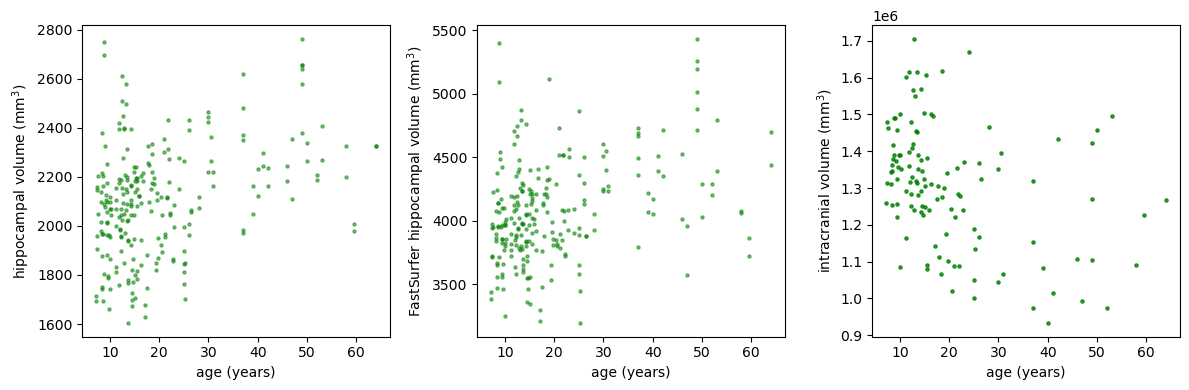

In [11]:

sexes=['male','female']
color = {'male':'blue', 'female':'pink',}
sub_features = ['.label-avg.hippunfold_volume','.label-avg.FS_volume', '.label-avg.total_volume']

fig = plt.figure(figsize=(12,4))
gs1 = gridspec.GridSpec(1, 3)
axs = []


for i,feature in enumerate(sub_features):
    axs.append(fig.add_subplot(gs1[i]))

    subdf = df.dropna(subset=[feature])

    #plot controls 
    subdf_c = subdf[subdf['group']=='C']
    sex_c = subdf_c['sex'].copy()
    age_c = subdf_c['age_scan'].copy()
    vals_c = subdf_c[feature].copy()
    axs[i].scatter(age_c,vals_c,c='green',s=5, alpha=0.5, label='healthy controls')
    axs[i].set_ylabel(return_features_title(feature, features_title))
    axs[i].set_xlabel('age (years)')

plt.tight_layout()

#### Plot correlation features with ICV 

In [8]:
from sklearn.linear_model import LinearRegression

In [9]:
# directory to save images
OUTPUT_PATH = os.path.join(BASE_PATH,'images')

0.000168454608762334
1884.1797027504108
1305936.5867768596
0.0002883505093694927
3702.780036019103
1305936.5867768596


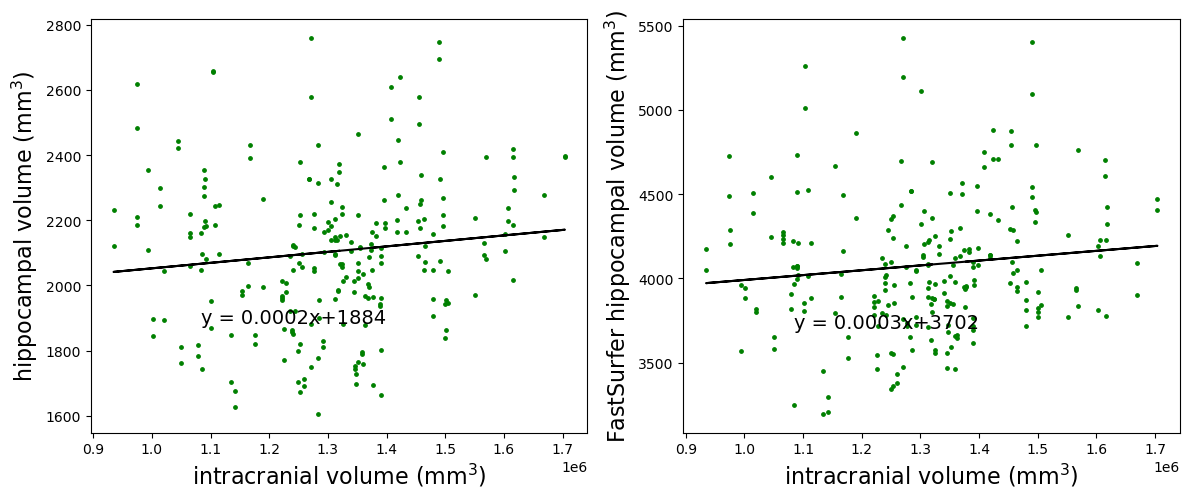

In [19]:
sub_features = ['.label-avg.hippunfold_volume', '.label-avg.FS_volume']
#select controls
df_c = df[df['group']=='C']

fig = plt.figure(figsize=(12,5))
gs1 = gridspec.GridSpec(1, 2)
axs = []

for i,feature in enumerate(sub_features):
    axs.append(fig.add_subplot(gs1[i]))

    subdf = df_c.dropna(subset=[feature])
    axs[i].scatter(subdf['.label-avg.total_volume'], subdf[feature], s=6, color='green')
    axs[i].set_ylabel(return_features_title(feature, features_title), fontsize = 16)
    axs[i].set_xlabel(return_features_title('.label-avg.total_volume', features_title), fontsize = 16)

    #fit linear regression
    reg = LinearRegression().fit(subdf[['.label-avg.total_volume']], subdf[feature])
    m = reg.coef_[0]
    print(m)
    b =reg.intercept_
    print(b)

    mean_icv = subdf['.label-avg.total_volume'].mean()
    print(mean_icv)
    
    axs[i].plot(subdf['.label-avg.total_volume'], m*subdf['.label-avg.total_volume']+b, color='black')
    axs[i].text(1.4e6,
                b,
                'y = {:.4f}x+{:d}'.format(m,int(b)),
                ha='right', fontsize=14)
plt.tight_layout()


fig.savefig(f'{OUTPUT_PATH}/correlation_volume_icv.png', dpi=96, transparent =True, bbox_inches = 'tight')